# Murilo Rossato Fernandes

# Redes Neurais Recorrentes - Comparação de modelos para predição do valor das ações da Petrobras

# Universidade Tecnológica Federal do Paraná

# Especialização em Ciência de Dados

# **Objetivo**: Comparar a acurácia de dois modelos de RNN, o univáriavel (leva em consideração apenas o valor da ação no tempo, e o multiváriavel (leva em consideração outros valores, como cotação do petróleo e índice Ibovespa). 

In [125]:
import datetime
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt   # plots/gráficos
import matplotlib.dates as mdates

import random                     # controle/geracao de numeros aleatorios
from statistics import mean       # media simples

# imports do sklearn
# metodologia experimental - divisão do dataset em subsets, e avaliação de performance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# medidas de desempenho e plot de matriz de confusão
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error as mae
# preprocessamento, se necessário, dos atributos
from sklearn import preprocessing
from sklearn import utils
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout


In [126]:
# seed para reprodução dos experimentos
seed = 42
random.seed(seed)
np.random.seed(seed)

# Coleta de dados

In [127]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [128]:
path = '/content/drive/MyDrive/CSV/BrentOilPrices.csv'
brent = pd.read_csv(path)

path2 = '/content/drive/MyDrive/CSV/b3_stocks_1994_2020.csv'
bov = pd.read_csv(path2)

path3 = '/content/drive/MyDrive/CSV/selic.csv'
selic = pd.read_csv(path3)

path4 = '/content/drive/MyDrive/CSV/usd2brl.csv'
dolar = pd.read_csv(path4)

# Compreensão dos dados

datetime -> Dia da cotação

ticker -> Código da ação na bolsa de valores

open -> Valor de abertura da ação no dia

close -> Valor de fechamento

high - > Máximo valor da ação no dia

low -> Valor mínimo da ação no dia

volume -> Quantidade de ações negociadas

selic -> Valor da taxa Selic (juros) no dia

usd_brl -> Cotação do dólar

Brent -> Cotação do petróleo

# Limpeza de dados

In [129]:
bov['ticker'] = bov['ticker'].str.replace(' ','')

In [130]:
brent['Date'] = pd.to_datetime(brent.Date)

In [131]:
brent.rename({'Date' : 'datetime'} , axis='columns', inplace='True')
brent.rename({'Price' : 'Brent'} , axis='columns', inplace='True')

In [132]:
petro = bov[bov['ticker'] == 'PETR4']

In [133]:
# Agrupando os dados em um dataset

df_aux = petro.merge(selic, on='datetime')
df_aux1 = df_aux.merge(dolar, on='datetime')
df_aux1['datetime'] = df_aux1['datetime'].astype('datetime64[ns]')
brent['datetime'] = brent['datetime'].astype('datetime64[ns]')
df_all = df_aux1.merge(brent, on='datetime')
df_all.reset_index()

,index,datetime,ticker,open,close,high,low,volume,selic,usd_brl,Brent
0,0,1998-03-16,PETR4,276.00,275.00,276.00,273.99,2.707893e+07,0.000969,1.1335,11.74
1,1,1998-03-17,PETR4,275.00,277.00,278.00,274.50,4.104903e+07,0.000965,1.1335,11.05
2,2,1998-03-18,PETR4,277.00,275.50,279.00,275.00,4.050641e+07,0.000965,1.1344,12.21
3,3,1998-03-19,PETR4,275.50,275.50,277.00,272.00,2.980126e+07,0.000959,1.1344,12.41
4,4,1998-03-20,PETR4,277.00,279.00,280.00,276.00,2.671342e+07,0.000963,1.1346,12.35
...,...,...,...,...,...,...,...,...,...,...,...
5536,5536,2020-12-22,PETR4,27.20,27.28,27.47,27.05,1.268321e+09,0.000075,5.1473,49.88
5537,5537,2020-12-23,PETR4,27.43,27.95,28.25,27.35,1.368939e+09,0.000075,5.1740,51.05
5538,5538,2020-12-28,PETR4,28.36,28.18,28.52,28.18,1.027841e+09,0.000075,5.2390,50.88
5539,5539,2020-12-29,PETR4,28.38,28.27,28.43,27.99,8.433475e+08,0.000075,5.1942,50.44


In [134]:
# Verificando valores faltantes

df_all.isna().sum()

datetime    0
ticker      0
open        0
close       0
high        0
low         0
volume      0
selic       0
usd_brl     0
Brent       0
dtype: int64

In [135]:
# Definindo o período que será análisado e removendo a coluna ticker, pois os dados já estão filtrados

df_all = df_all[(df_all['datetime'] > '2014-01-01')]
df_all.drop('ticker',axis='columns', inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [136]:
df_all.head()

,datetime,open,close,high,low,volume,selic,usd_brl,Brent
3832,2014-01-02,17.15,16.75,17.20,16.65,291684421.0,0.000375,2.3975,107.94
3833,2014-01-03,16.74,16.42,16.78,16.42,295038188.0,0.000375,2.3741,106.57
3834,2014-01-06,16.45,16.62,16.64,16.16,337127621.0,0.000375,2.3789,106.71
3835,2014-01-07,16.65,16.16,16.83,16.16,314019662.0,0.000375,2.3634,107.01
3836,2014-01-08,16.27,16.19,16.39,16.15,258052487.0,0.000375,2.3779,107.42


In [137]:
# Lista de características que serão utilizadas no modelo multivariável
FEATURES = ['open', 'usd_brl', 'close', 'volume', 'selic', 'Brent']

print('FEATURE LIST')
print([f for f in FEATURES])

data = pd.DataFrame(df_all)
data_filtered = data[FEATURES]

data_filtered.tail()

FEATURE LIST
['open', 'usd_brl', 'close', 'volume', 'selic', 'Brent']


,open,usd_brl,close,volume,selic,Brent
5536,27.20,5.1473,27.28,1.268321e+09,0.000075,49.88
5537,27.43,5.1740,27.95,1.368939e+09,0.000075,51.05
5538,28.36,5.2390,28.18,1.027841e+09,0.000075,50.88
5539,28.38,5.1942,28.27,8.433475e+08,0.000075,50.44
5540,28.35,5.1967,28.34,1.047992e+09,0.000075,50.74


In [138]:
# Selecionando os dados para a aplicação LSTM univariável

df_univar = df_all[['datetime', 'close']]
df_univar.head()

,datetime,close
3832,2014-01-02,16.75
3833,2014-01-03,16.42
3834,2014-01-06,16.62
3835,2014-01-07,16.16
3836,2014-01-08,16.19


# Analisando os dados

In [139]:
data_filtered.corr()

,open,usd_brl,close,volume,selic,Brent
open,1.000000,0.337358,0.998075,0.603567,-0.772497,0.271892
usd_brl,0.337358,1.000000,0.337242,0.418556,-0.675556,-0.636284
close,0.998075,0.337242,1.000000,0.600940,-0.772819,0.272457
volume,0.603567,0.418556,0.600940,1.000000,-0.584829,-0.005208
selic,-0.772497,-0.675556,-0.772819,-0.584829,1.000000,0.023773
Brent,0.271892,-0.636284,0.272457,-0.005208,0.023773,1.000000


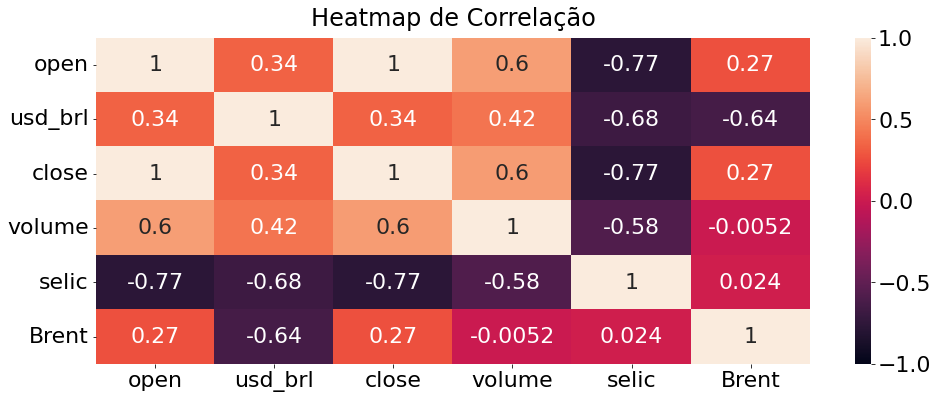

In [140]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(data_filtered.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Heatmap de Correlação', fontdict={'fontsize':24}, pad=12);

A maioria dos dados tem uma correlação relevante com o valor de fechamento da ação (target), inclusive a Selic tem um valor negativo, o que faz sentido pois a taxa de juros influencia no valor da ação.
O Brent deveria ter uma correlação maior, pois o lucro da empresa vem do petróleo, mas pode não estar ocorrendo essa correlação devido à ruídos políticos na empresa.

Nota: Repeti o experimento excluindo variáveis de correlação baixa, mas a conclusão foi a mesma.


In [141]:
data_plot = df_univar

In [142]:
data_plot.index = data_plot.datetime
data_plot.drop('datetime', axis=1, inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [143]:
data_plot

,close
datetime,
2014-01-02,16.75
2014-01-03,16.42
2014-01-06,16.62
2014-01-07,16.16
2014-01-08,16.19
...,...
2020-12-22,27.28
2020-12-23,27.95
2020-12-28,28.18


Text(0.5, 0, 'Data')

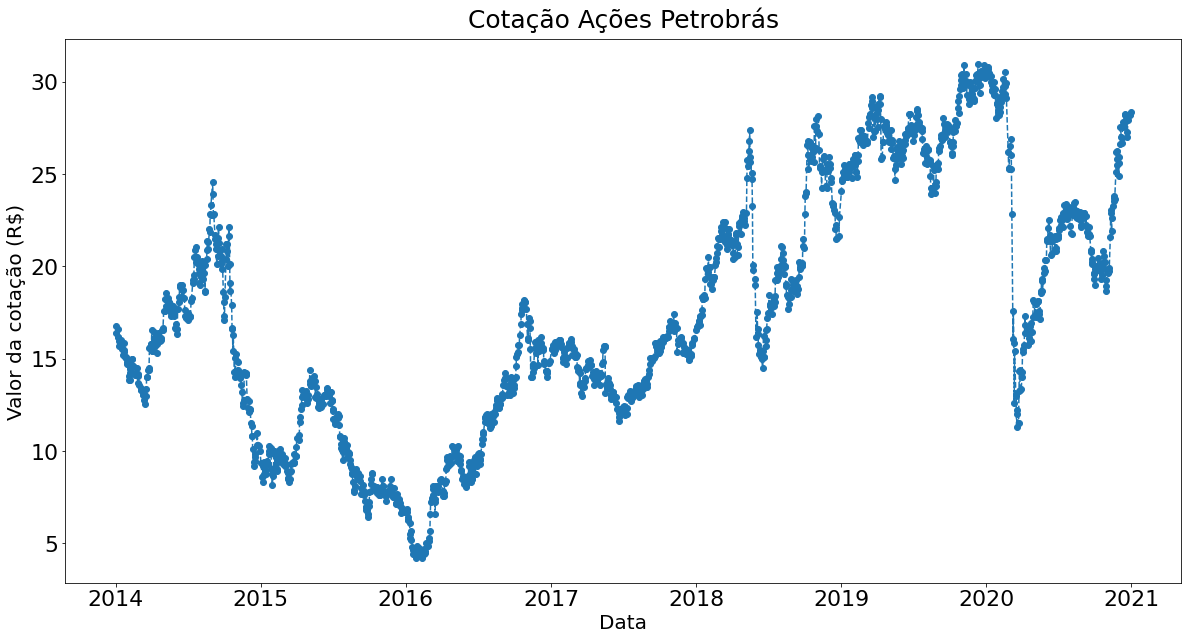

In [144]:
plt.figure(figsize=(20,10))
plt.plot(data_plot, marker='o', linestyle="--")
plt.title('Cotação Ações Petrobrás', fontdict={'fontsize':25}, pad=12);
plt.ylabel("Valor da cotação (R$)")
plt.xlabel("Data")

In [145]:
plot_brent = brent[(brent['datetime'] > '2016-01-01')]
plot_brent.index = plot_brent.datetime
plot_brent.drop('datetime', axis=1, inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Text(0.5, 0, 'Data')

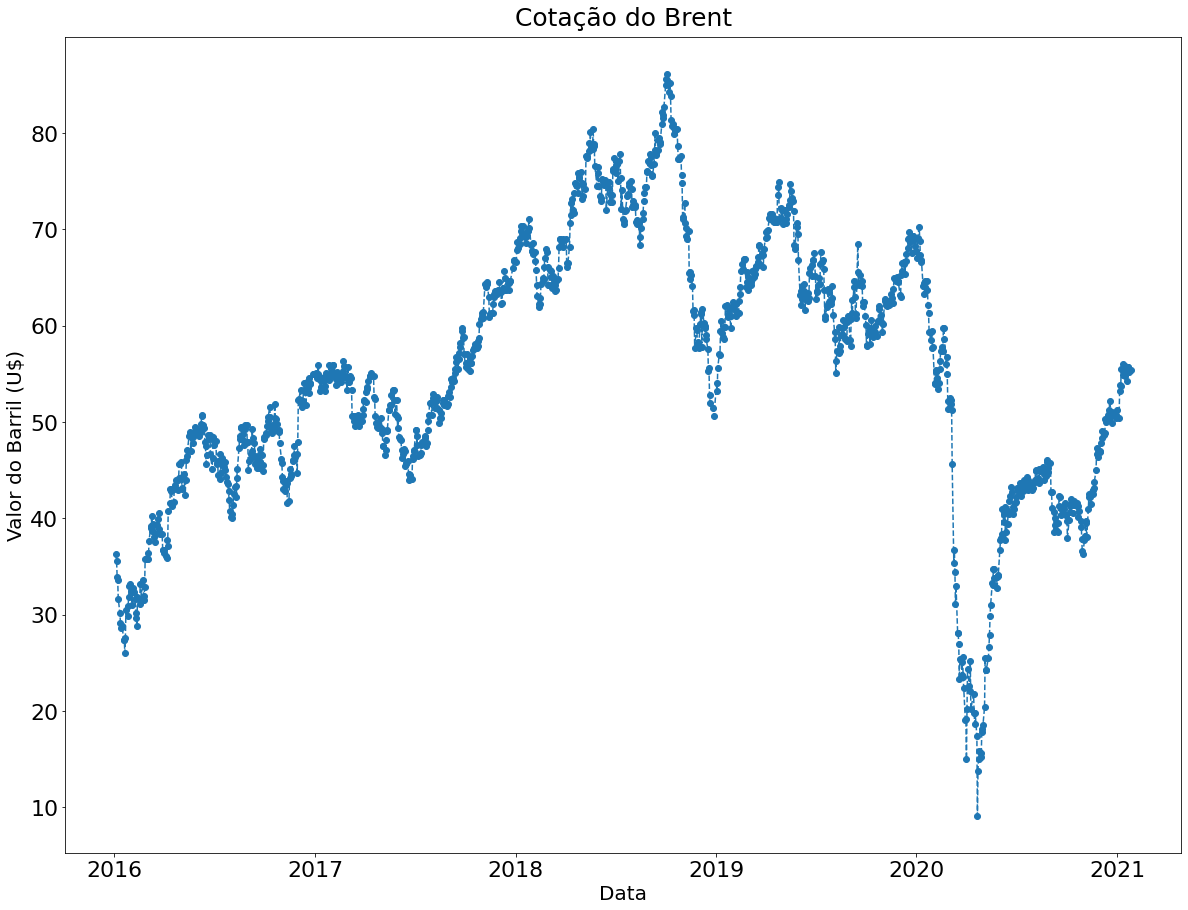

In [146]:
plt.figure(figsize=(20,15))
plt.rcParams['axes.labelsize'] = 20
plt.plot(plot_brent, marker='o', linestyle="--")
plt.title('Cotação do Brent', fontdict={'fontsize':25}, pad=12);
plt.ylabel("Valor do Barril (U$)")
plt.xlabel("Data")

# Treinamento do modelo univariável

In [147]:
df1=df_univar.reset_index()['close']

In [148]:
df1

0       16.75
1       16.42
2       16.62
3       16.16
4       16.19
        ...  
1704    27.28
1705    27.95
1706    28.18
1707    28.27
1708    28.34
Name: close, Length: 1709, dtype: float64

In [149]:
# Normalização dos dados

scaler_uni=MinMaxScaler(feature_range=(0,1))
df1=scaler_uni.fit_transform(np.array(df1).reshape(-1,1))

In [150]:
# Separando conjunto de treino e teste

training_size=int(len(df1)*0.75)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [151]:
training_size,test_size

(1281, 428)

In [152]:
# Convertendo o vetores de valores em um dataset matriz

def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [153]:
time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [154]:
print(X_train.shape), print(y_train.shape)

(1220, 60)
(1220,)


(None, None)

In [155]:
# Reajustando para aplicação do LSTM

X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [156]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(60,1)))
model.add(Dropout(rate = 0.2))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [157]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 60, 50)            10400     
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_13 (LSTM)              (None, 60, 50)            20200     
                                                                 
 lstm_14 (LSTM)              (None, 50)                20200     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [158]:
model.compile(loss='mean_squared_error', 
              optimizer='adam', 
              metrics=["MeanSquaredError", "RootMeanSquaredError", "MeanAbsoluteError"]
) 

In [159]:
history = model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=60,verbose=1)

Epoch 1/100
21/21 [==============================] - 11s 199ms/step - loss: 0.0319 - mean_squared_error: 0.0319 - root_mean_squared_error: 0.1787 - mean_absolute_error: 0.1312 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_root_mean_squared_error: 0.1063 - val_mean_absolute_error: 0.0658
Epoch 2/100
21/21 [==============================] - 3s 129ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - root_mean_squared_error: 0.0800 - mean_absolute_error: 0.0622 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_root_mean_squared_error: 0.0988 - val_mean_absolute_error: 0.0596
Epoch 3/100
21/21 [==============================] - 3s 126ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - root_mean_squared_error: 0.0624 - mean_absolute_error: 0.0459 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - val_root_mean_squared_error: 0.0973 - val_mean_absolute_error: 0.0613
Epoch 4/100
21/21 [==============================] - 3s 131ms/step - loss: 0.0035 - mean_squared_error

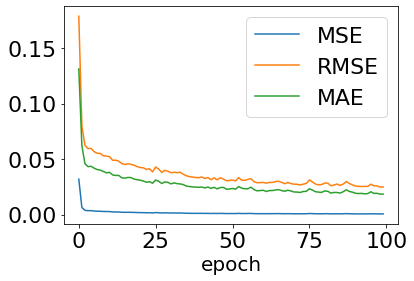

In [160]:
# Analisando redução do erro do modelo durante o treinamento

plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['mean_absolute_error'])
plt.xlabel('epoch')
plt.legend(['MSE', 'RMSE', 'MAE'], loc='upper right')
plt.show()

In [162]:
# Realizando predições

train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

12/12 [==============================] - 0s 25ms/step


In [163]:
# Retornando os valores às escalas normais

train_predict=scaler_uni.inverse_transform(train_predict)
test_predict=scaler_uni.inverse_transform(test_predict)
ytest = scaler_uni.inverse_transform(ytest.reshape(-1,1))

Calculando as métricas de performance

In [193]:
# Calculando as métricas de performance

MSE_uni = mean_squared_error(ytest,test_predict)
print(MES_uni)

MAE_uni = mae(ytest, test_predict)
print(MAE_uni)

0.7780460770966735
0.6087465160484211


In [166]:
# Preparação dos dados para a plotagem do resultado

trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_step:len(train_predict)+time_step, :] = train_predict

testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(time_step*2)+1:len(df1)-1, :] = test_predict

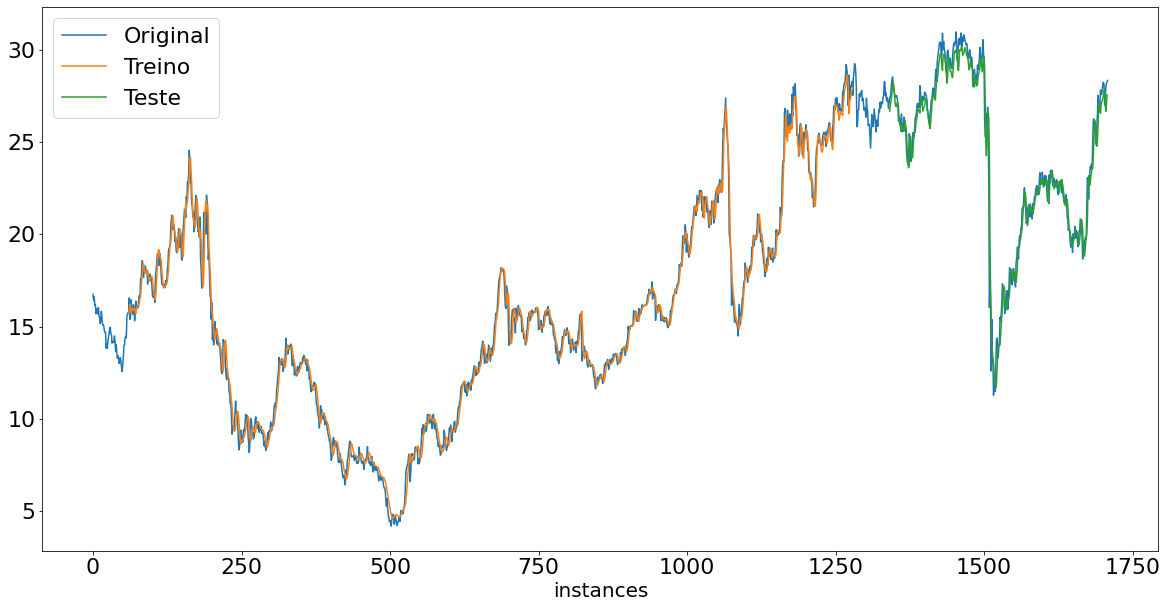

In [168]:
#Visualizando a Previsão
plt.rcParams.update({'font.size': 22})


plt.figure(figsize=(20,10))
plt.plot(scaler_uni.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.xlabel('instances')
plt.legend(['Original', 'Treino', 'Teste'], loc='upper left')
plt.show()

# Aplicando LSTM mutivariável para comparação de eficácia 

In [169]:
# Calculando o número de linhas dos dados
nrows = data_filtered.shape[0]

# Convertendo os dados em vetores
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Normalização dos dados
scaler = MinMaxScaler(feature_range=(0,1))
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Criando uma escala seperada que funciona como uma única coluna para previsões
scaler_pred = MinMaxScaler(feature_range=(0,1))
df_Close = pd.DataFrame(data_filtered['close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(1709, 6)


In [170]:
# Índice de previsão
index_Close = data.columns.get_loc("close")

# Separando os dados entre treino e teste
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.75)
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len:len(np_data_scaled), :]

# O RNN precisa de data no formalato de [amostras, período, features]
# Criados N amostras, sequence_lenght para o período por amostras e 6 features
def partition_dataset(time_step, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(time_step, data_len):
        x.append(data[i-time_step:i,:])
        y.append(data[i, index_Close])
    
    # Convertendo os valores para vetores
    x = np.array(x)
    y = np.array(y)
    return x, y

# Gerando os valores de treino e teste
x_train, y_train = partition_dataset(time_step, train_data)
x_test, y_test = partition_dataset(time_step, test_data)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1222, 60, 6) (1222,)
(367, 60, 6) (367,)
0.43369443406798647
0.43369443406798647


In [171]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(rate = 0.2))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [172]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 60, 50)            11400     
                                                                 
 dropout_5 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_16 (LSTM)              (None, 60, 50)            20200     
                                                                 
 lstm_17 (LSTM)              (None, 50)                20200     
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 51,851
Trainable params: 51,851
Non-trainable params: 0
_________________________________________________________________


In [173]:
model.compile(loss='mean_squared_error', 
              optimizer='adam', 
              metrics=["MeanSquaredError", "RootMeanSquaredError", "MeanAbsoluteError"]
) 

In [174]:
history = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,batch_size=60,verbose=1)

Epoch 1/100
21/21 [==============================] - 10s 198ms/step - loss: 0.0431 - mean_squared_error: 0.0431 - root_mean_squared_error: 0.2076 - mean_absolute_error: 0.1487 - val_loss: 0.0175 - val_mean_squared_error: 0.0175 - val_root_mean_squared_error: 0.1324 - val_mean_absolute_error: 0.0878
Epoch 2/100
21/21 [==============================] - 3s 128ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - root_mean_squared_error: 0.0838 - mean_absolute_error: 0.0634 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_root_mean_squared_error: 0.1192 - val_mean_absolute_error: 0.0886
Epoch 3/100
21/21 [==============================] - 3s 127ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - root_mean_squared_error: 0.0693 - mean_absolute_error: 0.0527 - val_loss: 0.0122 - val_mean_squared_error: 0.0122 - val_root_mean_squared_error: 0.1105 - val_mean_absolute_error: 0.0827
Epoch 4/100
21/21 [==============================] - 3s 127ms/step - loss: 0.0038 - mean_squared_error

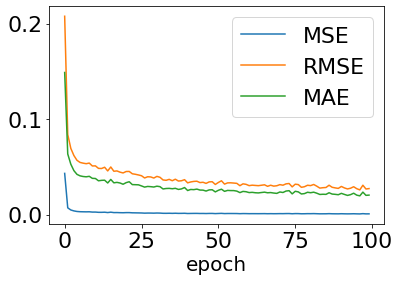

In [175]:
# Analisando o histórico de erro ao longo do treinamento

plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['mean_absolute_error'])
plt.xlabel('epoch')
plt.legend(['MSE', 'RMSE', 'MAE'], loc='upper right')
plt.show()

# Realizando as predições

In [176]:
train_predict_mult=model.predict(x_train)
test_predict_mult=model.predict(x_test)

12/12 [==============================] - 0s 26ms/step


In [177]:
# Retornando valores à escala original

test_unscaledmult = scaler_pred.inverse_transform(test_predict_mult)
train_unscaledmult = scaler_pred.inverse_transform(train_predict_mult)
y_test = scaler_pred.inverse_transform(y_test.reshape(-1,1))

In [184]:
# Calculando as métricas de avaliação

MSE_multi = mean_squared_error(y_test,test_unscaledmult)
print(MSE_multi)

MAE_mult = mae(y_test, test_unscaledmult)
print(MAE_mult)

4.712229183490966
1.72414210067458


# Plotando resultados

In [180]:
df1=data.reset_index()['close']
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [181]:
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_step:len(train_unscaledmult)+time_step, :] = train_unscaledmult

In [182]:
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_unscaledmult)+((time_step*2)-2)+1:len(df1)-1, :] = test_unscaledmult

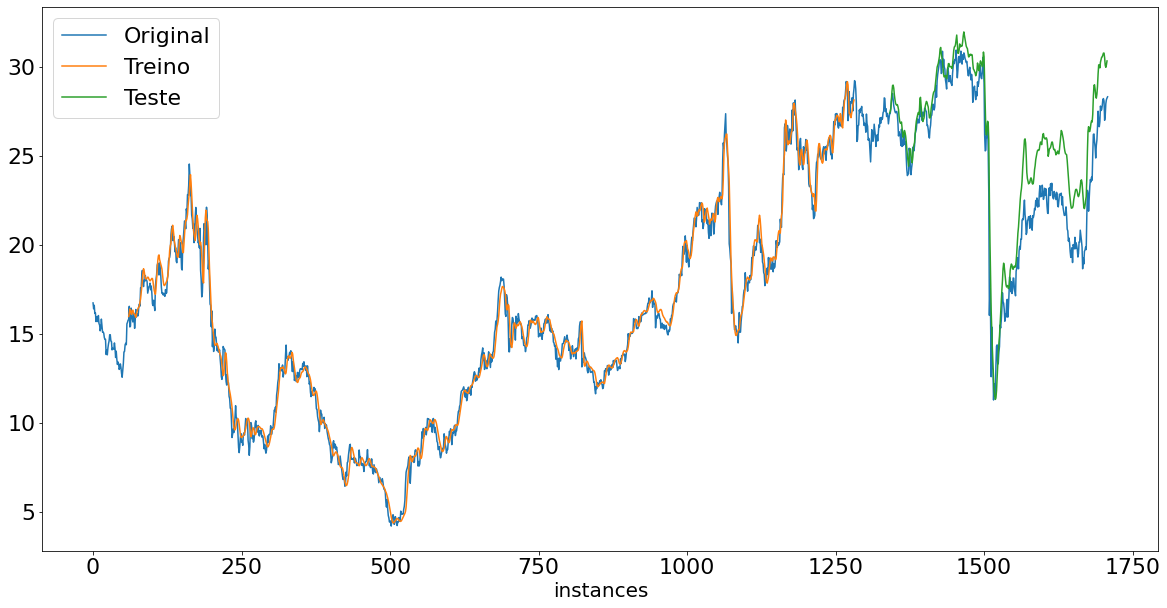

In [183]:
#Visualizando a Previsão
plt.rcParams.update({'font.size': 22})


plt.figure(figsize=(20,10))
plt.plot(scaler_uni.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.xlabel('instances')
plt.legend(['Original', 'Treino', 'Teste'], loc='upper left')
plt.show()

# Comparando os erros dos dois modelos

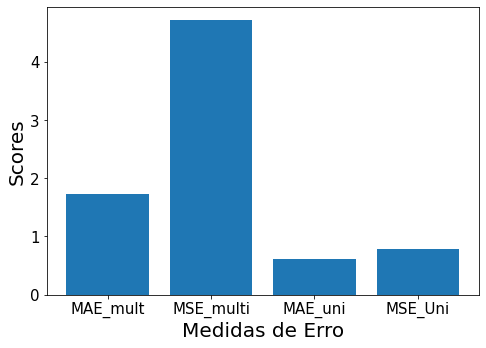

In [208]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
results = ['MAE_mult', 'MSE_multi', 'MAE_uni', 'MSE_Uni']
result = [MAE_mult, MSE_multi, MAE_uni, MSE_uni]
ax.bar(results, result)
ax.set_ylabel('Scores')
ax.set_xlabel("Medidas de Erro")
plt.show()

# Conclusão

O modelo univariável obteve uma melhor performance do que o multivariável no exemplo avaliado.
Para eliminar uma possível influência das escolhas sobre o resultado final foram alterados diversos hiperparâmetros, features escolhidas e modelo do LSTM, mas o resultado foi sempre o mesmo - melhor performance do univariável.
